# Basic Policy Gradients (REINFORCE) example in PyTorch

Adaptation of lab 6 by Víctor Campos to PyTorch

## Installing dependences



In [1]:
!apt-get update > /dev/null
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig > /dev/null
!pip install gym pyvirtualdisplay > /dev/null


Extracting templates from packages: 100%


## Torch + torchvision installation (Py3.6)

In [2]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl > /dev/null
!pip3 install torchvision > /dev/null
!apt-get install python-opengl > /dev/null

tcmalloc: large alloc 1073750016 bytes == 0x55e98000 @  0x7f9ca3b322a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch # Check if everything is OK

## Setting up the environment

In [4]:
import gym
import math
import random
import numpy as np

# Some stuff that we will need to visualize the simulations in the notebook
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import torch.nn.utils as utils
from torch.distributions import Categorical

env = gym.make('CartPole-v0')

print("Action space (discrete): {}".format( env.action_space.n))
print("Observation space (discrete): {}".format( env.observation_space))

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Action space (discrete): 2
Observation space (discrete): Box(4,)


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Create the model

Definition of the models tried accepting both image or env observations

In [0]:
class PolicyNN(nn.Module):
  def __init__(self,obs_dim=4, num_actions=2):
    super(PolicyNN, self).__init__()
    self.fc1 = nn.Sequential(
      nn.Linear(obs_dim, 16),
      nn.Tanh())
    self.fc2 = nn.Sequential(
      nn.Linear(16, 16),
      nn.Tanh())
    self.fc3 =  nn.Linear(16, num_actions)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    logprobs = self.fc3(x)
    return F.softmax(logprobs)
  
class PolicyNN_V2(nn.Module):
  def __init__(self,obs_dim=4, num_actions=2):
    super(PolicyNN_V2, self).__init__()
    self.fc1 = nn.Sequential(
      nn.Linear(obs_dim, 16),
      nn.ReLU())
    self.fc2 = nn.Sequential(
      nn.Linear(16, 32),
      nn.ReLU())
    self.fc3 =  nn.Linear(32, num_actions)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    logprobs = self.fc3(x)
    return F.softmax(logprobs)
  
  
class ImagePolicy(nn.Module):

    def __init__(self):
        super(ImagePolicy, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Sequential(
            nn.Linear(448, 512),
            nn.Dropout(),
            nn.Linear(512, 2))
            
                              

    def forward(self, x):
        #print ("input size: {} \n".format(x.size()))
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        res= F.softmax(self.head(x.view(x.size(0), -1)))
        #print ("Soft out: {}".format(res))
        return res

In [0]:
import sys


resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

class Agent:
  '''
  Implements reinforce algorithm
  Param:
  - Config file example:
     env = "CartPole-v0" # Choose your env (not checked if working xddd)
    seed = 0  # for reproducibility0
    gamma = 0.99  # discount factor for future rewards
    batch_size = 64  # in trajectories (episodes)
    learning_rate = 0.0001
    use_images = True Use env states or rgb frames from env.render
  
  - Additional params
  - decay -> Learning rate decay--> configured to reduce lr by 0.3 after each 1000 episodes
  - use_entropies -> use entropy normalization, TODO: add decay factor also
  '''
  def __init__(self, config, use_entropies = True, decay= False, relu= True):
    # Get configs and init model, optimizer, lr decay scheduler...
    self.use_images = config.use_images
    if self.use_images:
      self.pi = ImagePolicy()
      self.env = gym.make(config.env).unwrapped
    else:
      self.env = gym.make(config.env)
      if relu:
        self.pi = PolicyNN_V2()
      else:
        self.pi = PolicyNN()
    
    
    self.gamma = config.gamma  # discount factor for future rewards
    self.batch_size = config.batch_size  # in 4trajectories (episodes)
    self.optimizer = torch.optim.Adam(self.pi.parameters(), lr=config.learning_rate) # optiii
    self.use_entropies= use_entropies
    # Set random seed for reproducibility
    self.env.seed(config.seed)
    #torch.manual_seed(config.seed)
    self.decay=decay
    if decay:
       self.decay_lr= optim.lr_scheduler.StepLR(self.optimizer, step_size=int(1000/self.batch_size), gamma=0.5)

    self.pi.train() # DONT FORGET TO PUT MODEL TO TRAIN ON INIT!!!!!!!
    # This is based on the code from gym.
    self.screen_width = 600
  
  
  def save(self, filename):
    """ Save policy weights to a ***.h5 file. """
    self.pi.save_state_dict(filename)
    #self.pi.save_weights(filename)
    
  def load(self, filename):
    """ Load policy weights from a ***.h5 file. """
    #self.pi.load_weights(filename)
    self.pi.load_state_dict(torch.load(filename))
    
  def get_cart_location(self):
    world_width = self.env.x_threshold * 2
    scale = self.screen_width / world_width
    return int(self.env.state[0] * scale + self.screen_width / 2.0)  # MIDDLE OF CART
   
  def get_screen(self):
    screen = self.env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = self.get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (self.screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

  def select_action(self, state):
    probs = self.pi(Variable(state))    
    c = Categorical(probs)
    action = probs.multinomial(num_samples=1).data
    prob = probs[:, action[0,0]].view(1, -1)
    log_prob = prob.log()
    entropy = - (probs*probs.log()).sum()
    return action[0], log_prob, entropy
  
  def play(self, render):
    """ 
    Run the trained policy on the env. 
    Returns the rewards and the rendered frames for visualization.
    """
    # put model to eval
    self.pi.eval()
    state = torch.Tensor([self.env.reset()])
    if self.use_images:
      last_screen = self.get_screen()
    done = False
    rews, frames = [], []
    while not done:
      if render:
        frames.append(self.env.render(mode='rgb_array'))
      # We need to convert ob to a tensor, and add a batch dimension...
      # ... and remove it again once we are done with TF ops
      if self.use_images:
        action, log_prob, entropy  = self.select_action(last_screen)
      else:
        action, log_prob, entropy  = self.select_action(state)
      next_state, rew, done, info = self.env.step(action.numpy()[0])
      state = torch.Tensor([next_state])
      if self.use_images:
        last_screen = self.get_screen()- last_screen
      rews.append(rew)
    return rews, frames
  
  def _discount_rewards(self, rews):
    """ 
    Compute discounted rewards recursively. 
    Recall that with discount, r_t = sum_{k=t}^{T} gamma^{k-t} * r_k
    """
    discounted_rews = []
    last_r = 0.
    for r in reversed(rews):
      last_r = last_r * self.gamma + r
      discounted_rews.append(last_r)
    discounted_rews.reverse()
    return discounted_rews
  

  def _compute_gradients_torch(self, rewards, log_probs, entropies, n_ep):
    """
    Implement the policy gradient in Torch. In order to do so with automatic
    differentiation, we need to build a surrogate loss whose gradient is 
    the policy gradient.
    This is achieved by taking the logprob of the selected action and 
    scaling it by the discounted reward and adding it the entropy factor ( or substracting depending on the view).
"""
    R = torch.zeros(1, 1)
    self.pi.train() #ojuu que el posarem a val a la funcio play
    loss = 0
    for i in reversed(range(len(rewards))):
        if n_ep<1000: 
          a=0.0001
        else:
          a=0
        R = self.gamma * R + rewards[i]
        if self.use_entropies:
          loss = loss - (log_probs[i]*(Variable(R).expand_as(log_probs[i]))).sum() - a*entropies[i].sum()
        else:
          loss = loss - (log_probs[i]*(Variable(R).expand_as(log_probs[i]))).sum() 

        
        
    self.optimizer.zero_grad()
    loss.backward()
    utils.clip_grad_norm(self.pi.parameters(), 40*self.batch_size)
    self.optimizer.step()
    if self.decay:
      self.decay_lr.step()
    return rewards, loss
                         
  def train(self, num_episodes):
    """
    Training loop:
      1. Collect experience by running the policy on the env
      2. Estimate the policy gradient with samples
      3. Update the policy and go back to (1)
    """
    rew_hist=[]
    eval_cum_rews_history=[]
    entropies = []
    log_probs = []
    losses=[]
    rewards = []
    for i_episode in range(num_episodes):
        state = torch.Tensor([self.env.reset()])
        if self.use_images:
          last_screen = self.get_screen()

        done=False
        while not done: #PLAY PLAY
            if self.use_images:
              action, log_prob, entropy = self.select_action(last_screen)
            else:
              action, log_prob, entropy = self.select_action(state)
            action = action
            next_state, reward, done, _ = self.env.step(action.numpy()[0])
            entropies.append(entropy)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = torch.Tensor([next_state])
            if self.use_images:
              last_screen = self.get_screen()- last_screen

            if done:
                break
        if i_episode%self.batch_size==0: #UPDATE GRADIENTSSSS AND VAL THE AGENT WITH ONE EPISODE
            ep_rew,loss=self._compute_gradients_torch(rewards, log_probs, entropies, i_episode+1)

            rew_hist.append(ep_rew)
            eval_rews, _ = self.play(render=False)
            eval_cum_rew = np.sum(eval_rews)
            eval_cum_rews_history.append(eval_cum_rew)
            losses.append(loss)
            entropies = []
            log_probs = []
            rewards = []
            torch.save(self.pi.state_dict(), 'wpt.pkl')
            sys.stdout.write('\r%s %s %s %s %s %s %s %s' % ('Train rew avg: ', np.array(ep_rew).sum()/self.batch_size, ' val: ', eval_cum_rew, 'Episode: ',i_episode, '        ', '              '))
            sys.stdout.flush()

    return eval_cum_rews_history, losses


In [0]:

class CartPoleConfig:
  env = "CartPole-v0"
  seed = 0  # for reproducibility0
  gamma = 0.99  # discount factor for future rewards
  batch_size = 1  # in trajectories (episodes)
  learning_rate = 0.001
  use_images = False
  

entropic_agent = Agent(CartPoleConfig, relu=True, use_entropies = True)
agent = Agent(CartPoleConfig, relu=True, use_entropies = False)

n_experiments = 1
entropic_rewards=[]
normal_rewards= []
# Training on 3000 episodes takes around 3:30min on CPU
for _i in range(n_experiments):
  print("Experiment: {}".format(_i+1))
  reward,loss = agent.train(num_episodes=2500)
  print (" Loss: {} Reward: {} \n".format(reward, loss))
  loss=[]
  normal_rewards.append(reward)
  agent=0
  reward,loss = entropic_agent.train(num_episodes=2500)
  loss=[]
  entropic_rewards.append(reward)
  #upss, dont forget to go back to dumb agent!!!
  entropic_agent = Agent(CartPoleConfig, relu=True)
  agent = Agent(CartPoleConfig, relu=False)
  print("Entropic Loss: {} Reward: {} \n".format(reward, loss))
  CartPoleConfig.seed+=1
 


Experiment: 1
Train rew avg:  16.0  val:  16.0 Episode:  8                        

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:167: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train rew avg:  30.0  val:  57.0 Episode:  399                        

KeyboardInterrupt: ignored

In [9]:
#!sudo pip3 install PyOpenGL
#!sudo pip3 install piglet
#!sudo pip3 install pyglet


class CartPoleConfig:
  env = "CartPole-v0"
  seed = 0  # for reproducibility0
  gamma = 0.99  # discount factor for future rewards
  batch_size = 16  # in trajectories (episodes)
  learning_rate = 0.0001
  use_images = True
  

entropic_agent = Agent(CartPoleConfig, use_entropies=True)
agent = Agent(CartPoleConfig, use_entropies=False)

n_experiments = 1
entropic_rewards=[]
normal_rewards= []
# Training on 3000 episodes takes around 3:30min on CPU
for _i in range(n_experiments):
  print("Experiment: {}".format(_i+1))
  reward,loss = agent.train(num_episodes=1)
  print (" Loss: {} Reward: {} \n".format(reward, loss))
  
  normal_rewards.append(reward)
  reward,loss = entropic_agent.train(num_episodes=3500)
  entropic_rewards.append(reward)
  #upss, dont forget to go back to dumb agent!!!
  entropic_agent = Agent(CartPoleConfig, use_entropies=True)
  agent = Agent(CartPoleConfig, use_entropies=False)
  print("Entropic Loss: {} Reward: {} \n".format(reward, loss))
  CartPoleConfig.seed+=1
  break


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Experiment: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train rew avg:  1.3125  val:  20.0 Episode:  0                        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


 Loss: [20.0] Reward: [tensor(145.4342, grad_fn=<ThSubBackward>)] 

Train rew avg:  25.5  val:  17.0 Episode:  3488                        Entropic Loss: [37.0, 40.0, 38.0, 38.0, 23.0, 18.0, 21.0, 65.0, 43.0, 15.0, 16.0, 14.0, 15.0, 19.0, 25.0, 24.0, 11.0, 77.0, 17.0, 21.0, 48.0, 11.0, 18.0, 26.0, 17.0, 19.0, 20.0, 32.0, 11.0, 16.0, 22.0, 11.0, 12.0, 14.0, 17.0, 29.0, 10.0, 23.0, 22.0, 35.0, 16.0, 81.0, 13.0, 21.0, 14.0, 35.0, 11.0, 14.0, 42.0, 46.0, 34.0, 12.0, 30.0, 38.0, 25.0, 10.0, 25.0, 29.0, 11.0, 17.0, 28.0, 56.0, 24.0, 11.0, 14.0, 11.0, 17.0, 22.0, 62.0, 16.0, 21.0, 15.0, 25.0, 32.0, 23.0, 27.0, 31.0, 25.0, 32.0, 35.0, 16.0, 20.0, 24.0, 16.0, 11.0, 30.0, 29.0, 11.0, 33.0, 22.0, 25.0, 11.0, 13.0, 27.0, 28.0, 23.0, 25.0, 10.0, 22.0, 10.0, 20.0, 11.0, 15.0, 18.0, 24.0, 26.0, 14.0, 18.0, 30.0, 9.0, 14.0, 12.0, 34.0, 13.0, 31.0, 16.0, 18.0, 26.0, 17.0, 21.0, 63.0, 25.0, 32.0, 14.0, 51.0, 13.0, 28.0, 36.0, 13.0, 18.0, 65.0, 13.0, 18.0, 25.0, 14.0, 20.0, 21.0, 11.0, 17.0, 14.0, 11.0, 

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(1,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


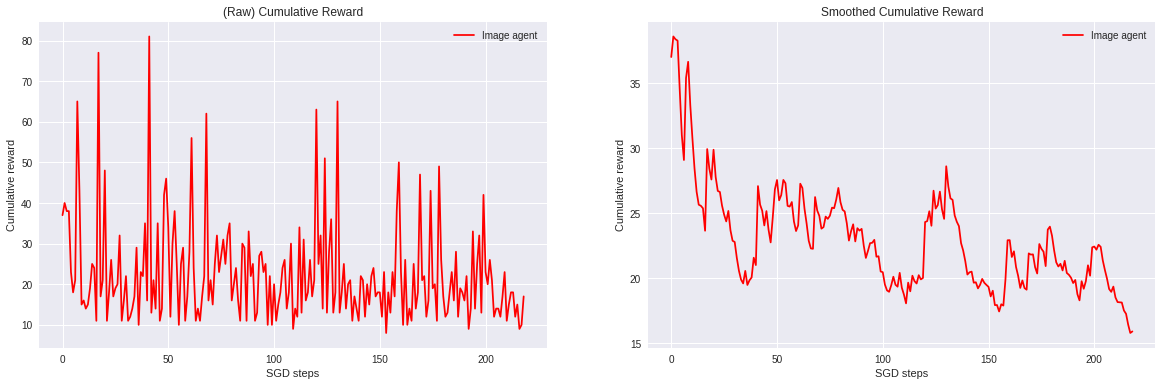

In [16]:
#upss importing her
import pandas as pd
def ewma(x, alpha):
    """
    Exponential Weighted Moving Average.
    Source: https://stackoverflow.com/a/42905202
    """
    x = np.array(x)
    n = x.size
    w0 = np.ones(shape=(n,n)) * (1-alpha) 
    p = np.vstack([np.arange(i,i-n,-1) for i in range(n)])
    w = np.tril(w0**p,0)
    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)


# Plot the reward, with and without EWMA smoothing
f = plt.figure(figsize=(20,6))

'''
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
'''

#avg rewards


#Change name, if u run it twiche u will loose ut rewards...
normal_rewards_a=np.mean(np.array(normal_rewards),axis=0)
entropic_rewards_a=np.mean(np.array(entropic_rewards),axis=0)

window = int(normal_rewards_a.shape[0]/20)
print(np.array(normal_rewards_a).shape)

entropic_std = pd.Series(entropic_rewards_a).rolling(window).std()
normal_std = pd.Series(normal_rewards_a).rolling(window).std()

axarr = plt.subplot(1,2,1)
#axarr.plot(ewma(normal_rewards_a, alpha=1.),color='blue')
axarr.plot(ewma(entropic_rewards_a, alpha=1.),color='red')

axarr.set_title('(Raw) Cumulative Reward')
axarr.set_ylabel('Cumulative reward')
axarr.set_xlabel('SGD steps')
axarr.legend(['Image agent'])
axarr = plt.subplot(1,2,2)
axarr.set_title('Smoothed Cumulative Reward')
#axarr.plot(ewma(normal_rewards_a, alpha=0.1),color='blue')
axarr.plot(ewma(entropic_rewards_a, alpha=0.1),color='red')
axarr.fill_between(range(normal_rewards_a.shape[0]),normal_rewards_a-normal_std, normal_rewards_a+normal_std, color='blue', alpha=0.2)
axarr.fill_between(range(normal_rewards_a.shape[0]),entropic_rewards_a-entropic_std, entropic_rewards_a+entropic_std, color='red', alpha=0.2)
axarr.legend(['Image agent'])

axarr.set_ylabel('Cumulative reward')
axarr.set_xlabel('SGD steps')

plt.show()

In [0]:
# Plot the reward, with and without EWMA smoothing
f = plt.figure(figsize=(20,6))
print(len(normal_rewards))
print(normal_rewards[0]==normal_rewards[3])
axarr = plt.subplot(1,2,1)
for _i in range(len(normal_rewards)):
  axarr.plot(ewma(normal_rewards[_i], alpha=1.))

axarr.set_title('(Raw) Cumulative Reward')
axarr.set_ylabel('Cumulative reward')
axarr.set_xlabel('SGD steps')

axarr = plt.subplot(1,2,2)
axarr.set_title('Smoothed Cumulative Reward')
for _i in range(len(normal_rewards)):
  axarr.plot(ewma(normal_rewards[_i], alpha=0.1))

axarr.set_ylabel('Cumulative reward')
axarr.set_xlabel('SGD steps')

plt.show()

In [0]:
# Let's visualize our trained policy
rews, frames = entropic_agent.play(render=True)
print("Cumulative reward:", np.sum(rews))

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), 
           dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                         interval=50)
HTML(ani.to_jshtml())

In [0]:


probs = torch.Tensor([[0.1 ,0.9]]) 
print(probs)

action = probs.multinomial(num_samples=1).data
print(action)

prob = probs[:, action[0,0]].view(1, -1)
print(prob)

log_prob = prob.log()
print(log_prob)

entropy = - (probs*probs.log()).sum()
print(entropy)
